# State tomography from a set of static measurements

In [14]:
import tensorflow as tf

import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output

## Constants

In [29]:
cutoff = 10

# Number of layers
depth = 20

# Standard deviation of initial parameters
passive_sd = 0.1
active_sd = 0.001

## Parameters

In [30]:
# squeeze gate
sq_r = tf.Variable(tf.random_normal(shape=[depth], stddev=active_sd))
sq_phi = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))

# displacement gate
d_r = tf.Variable(tf.random_normal(shape=[depth], stddev=active_sd))
d_phi = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))

# rotation gates
r1 = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))
r2 = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))

# kerr gate
kappa = tf.Variable(tf.random_normal(shape=[depth], stddev=active_sd))

## Construct the circuit

In [32]:
# layer architecture
def layer(i, q):
    Rgate(r1[i]) | q
    Sgate(sq_r[i], sq_phi[i]) | q
    Rgate(r2[i]) | q
    Dgate(d_r[i], d_phi[i]) | q
    Kgate(kappa[i]) | q

    return q

In [33]:
# Start SF engine
engine, q = sf.Engine(1)

# Apply circuit of layers with corresponding depth
with engine:
    for k in range(depth):
        layer(k, q[k])

# Run engine
state = engine.run('tf', cutoff_dim=cutoff, eval=False)
ket = state.ket()

## Cost and optimizer

### Cost

In [34]:
target_state = np.zeros([cutoff])
target_state[1] = 1
target_state

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [80]:
fidelity = tf.abs(tf.reduce_sum(tf.conj(ket) * target_state)) ** 2

In [86]:
epsilon = 1e-8
cost = -tf.log(tf.abs(tf.reduce_sum(tf.conj(ket) * target_state))**2 + epsilon)

### Optimizer

In [91]:
optimiser = tf.train.AdamOptimizer()
min_cost = optimiser.minimize(cost)

## Training

In [92]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [93]:
fid_progress = []
best_fid = 0
i = 0

In [99]:
# Run optimization
nb_iter = 1
for i in range(i, nb_iter+i):

    # one repitition of the optimization
    _, cost_val, fid_val, ket_val = session.run([min_cost, cost, fidelity, ket])

    # Stores fidelity at each step
    fid_progress.append(fid_val)

    if fid_val > best_fid:
        # store the new best fidelity and best state
        best_fid = fid_val
        learnt_state = ket_val

    # Prints progress at every 10 reps
    clear_output(wait=True)
    print("Rep: {} Cost: {:.4f} Fidelity: {:.4f}".format(i, cost_val, fid_val))
        
nb_iter += 1

Rep: 1107 Cost: 0.0022 Fidelity: 0.9978


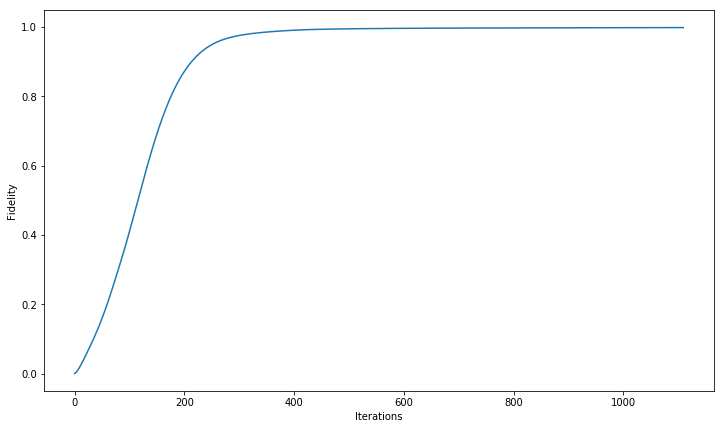

In [100]:
plt.rcParams['figure.figsize'] = (12,7)

plt.xlabel("Iterations")
plt.ylabel("Fidelity")
plt.plot(fid_progress)

## Result and visualization

In [101]:
%precision 2
np.set_printoptions(suppress=True)
print(learnt_state)

[ 0.03+0.01j  0.05+1.j   -0.02+0.01j -0.  -0.j   -0.01-0.j    0.  -0.j
 -0.  -0.j    0.  -0.j   -0.  -0.j   -0.  +0.j  ]
